In [1]:
#!/usr/bin/env python
# -------------------------------------------------------------------------
#  shared_gamma_sweep.py
#  Fast ALS with 10 restarts  +  spectrum-comparison overlay
# -------------------------------------------------------------------------
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal   import find_peaks
from scipy.optimize import minimize, minimize_scalar
from numpy.random   import default_rng

# ─────────────── configuration ────────────────────────────────────────────
folder        = Path("total_strength")   # <-- adjust if needed
max_files     = 20
n_range       = range(3, 11)             # 3 … 10
num_starts    = 10                       # restarts per n
outer_iters   = 3                        # ALS Γ ↔ μ cycles
prom_frac     = 0.02                     # peak prominence
Γ_min, Γ_max  = 0.30, 5.0                # physical Γ bounds (MeV)
tol_Γ         = 1e-4                     # Γ convergence
rng           = default_rng(42)          # reproducible randomness
jitter_frac   = 0.1                      # μ jitter in starts (10 % Γ)
ridge_λ       = 1e-8                     # tiny ridge for amplitude solve

# ─────────────── load data ────────────────────────────────────────────────
files = sorted(folder.glob("*.out"))[:max_files]
if not files:
    raise RuntimeError("No .out files found in ‘total_strength/’")

ω  = np.loadtxt(files[0])[:, 0]                        # common frequency grid
S  = np.vstack([np.loadtxt(f)[:, 1] for f in files])   # (K,L) spectra matrix
K, L = S.shape
dω   = np.median(np.diff(ω))
Γ_floor = max(2*dω, Γ_min)                             # ≥ two grid bins
print(f"Loaded {K} spectra   Γ floor = {Γ_floor:.3f} MeV\n")

# ─────────────── helper functions ─────────────────────────────────────────
def lor_basis(μ, Γ):
    """Basis matrix L_ij for Lorentzians (n, L)."""
    return Γ**2 / ((ω[None, :] - μ[:, None])**2 + Γ**2)

def best_amplitudes(μ, Γ, Sspec):
    """Analytic A that minimises ||Σ A_i L_i − S||₂ (ridge-regularised)."""
    L = lor_basis(μ, Γ)
    M = L @ L.T + ridge_λ * np.eye(len(μ))   # (n,n)
    b = L @ Sspec                            # (n,)
    return np.linalg.solve(M, b)             # (n,)

def spectrum_mse(A, μ, Γ, Sspec):
    diff = (A @ lor_basis(μ, Γ)) - Sspec
    return np.mean(diff**2)

def peak_seed(Sspec, n):
    peaks, props = find_peaks(Sspec, prominence=prom_frac * Sspec.max())
    order = np.argsort(props["prominences"])[::-1]
    μ = list(ω[peaks][order[:n]])
    while len(μ) < n:                        # pad if too few peaks
        μ.append(float(ω[np.argmax(Sspec)]))
    return np.array(sorted(μ)[:n])

def jitter(arr, scale):
    return arr + rng.uniform(-scale, scale, size=arr.shape)

def total_mse_all(μ_all, Γ):
    return np.mean([
        spectrum_mse(best_amplitudes(μ_all[k], Γ, S[k]), μ_all[k], Γ, S[k])
        for k in range(K)
    ])

# ─────────────── main sweep with restarts ─────────────────────────────────
avg_mse_vs_n = []
fit_by_n     = {}        # store best fit info for later plotting

for n in n_range:
    best_mse, best_Γ, best_μ_all = np.inf, None, None

    for start in range(num_starts):
        # ── randomised initial guess ──────────────────────────────────────
        Γ = rng.uniform(Γ_floor, 2.0)
        μ_all = np.vstack([jitter(peak_seed(S[k], n), jitter_frac * Γ)
                           for k in range(K)])

        # ── alternating Γ ↔ μ cycles ─────────────────────────────────────
        for _ in range(outer_iters):
            # —— optimise μ for each spectrum (Nelder–Mead, few steps) ——
            for k in range(K):
                Sspec = S[k]

                def mse_local(μ_flat):
                    A = best_amplitudes(μ_flat, Γ, Sspec)
                    return spectrum_mse(A, μ_flat, Γ, Sspec)

                res_loc = minimize(mse_local, μ_all[k], method='Nelder-Mead',
                                   options=dict(maxiter=60, xatol=1e-3))
                μ_all[k] = np.sort(res_loc.x)

            # —— optimise shared Γ (bounded Brent) ————————————————
            def mse_Γ(Γval):
                return 1e9 if Γval < Γ_floor else total_mse_all(μ_all, Γval)

            res_Γ = minimize_scalar(mse_Γ, bounds=(Γ_floor, Γ_max),
                                    method='bounded', options={'maxiter': 40})
            if abs(res_Γ.x - Γ) < tol_Γ:
                Γ = res_Γ.x
                break
            Γ = res_Γ.x

        mse_avg = total_mse_all(μ_all, Γ)
        if mse_avg < best_mse:
            best_mse, best_Γ, best_μ_all = mse_avg, Γ, μ_all.copy()

    avg_mse_vs_n.append(best_mse)
    fit_by_n[n] = dict(Γ=best_Γ, μs=best_μ_all)
    print(f"n={n:2d}   best of {num_starts}   Γ={best_Γ:.3f} MeV   "
          f"avg MSE={best_mse:.3e}")



Loaded 20 spectra   Γ floor = 0.300 MeV

n= 3   best of 10   Γ=1.213 MeV   avg MSE=5.007e-02
n= 4   best of 10   Γ=1.049 MeV   avg MSE=2.214e-02
n= 5   best of 10   Γ=1.143 MeV   avg MSE=1.528e-02
n= 6   best of 10   Γ=1.088 MeV   avg MSE=1.030e-02
n= 7   best of 10   Γ=1.078 MeV   avg MSE=7.638e-03
n= 8   best of 10   Γ=1.061 MeV   avg MSE=7.202e-03
n= 9   best of 10   Γ=1.067 MeV   avg MSE=6.566e-03
n=10   best of 10   Γ=1.079 MeV   avg MSE=6.449e-03


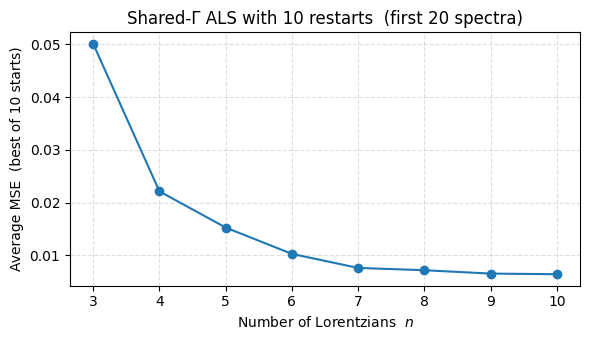

In [4]:
# ─────────────── average-error curve ──────────────────────────────────────
plt.figure(figsize=(6, 3.5))
plt.plot(list(n_range), avg_mse_vs_n, "o-")
plt.xlabel("Number of Lorentzians  $n$")
plt.ylabel("Average MSE  (best of 10 starts)")
plt.title("Shared-Γ ALS with 10 restarts  (first 20 spectra)")
plt.grid(ls="--", alpha=.4)
plt.tight_layout(); plt.show()



Overlaying fits for random spectrum: strength_1.0000_1.4860.out  (index 10)


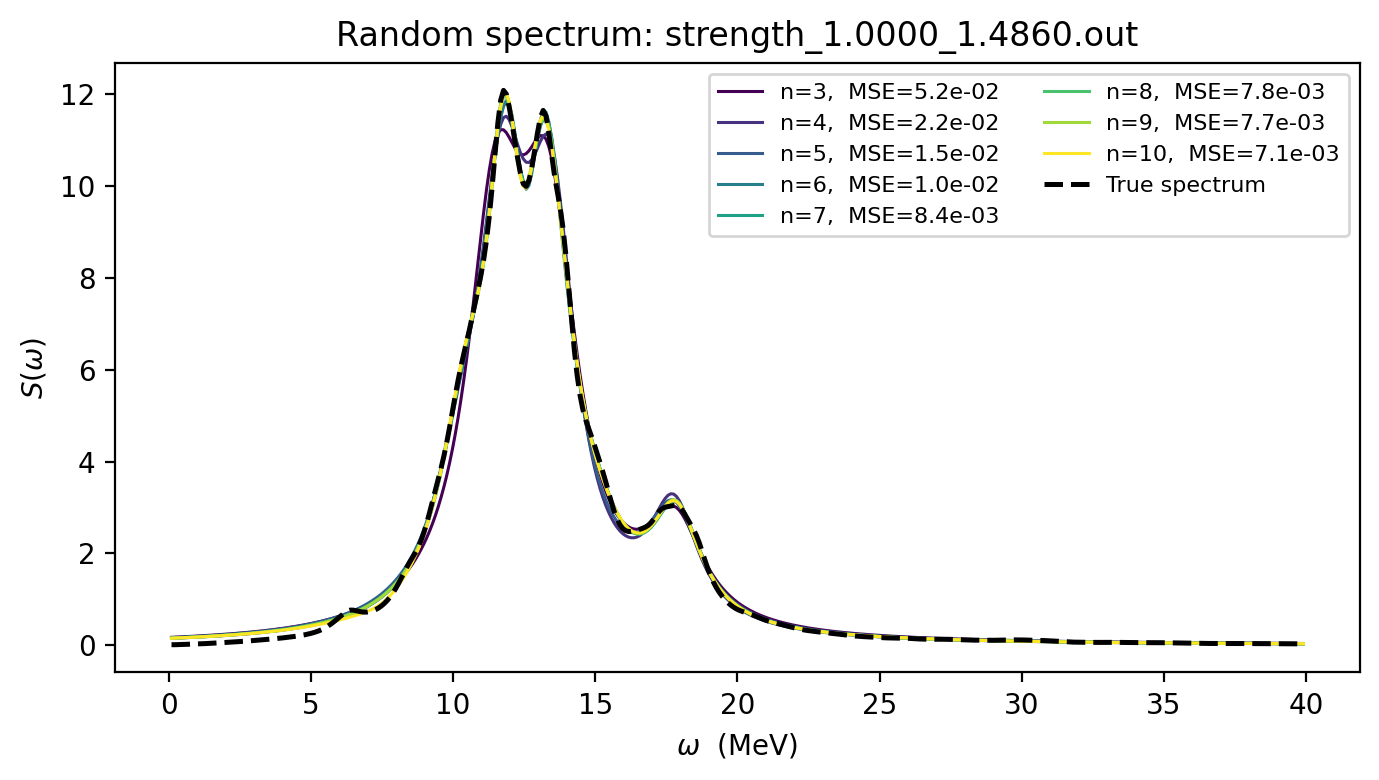

In [10]:
# ───────── overlay for a random spectrum ────────────────────────────────
# idx   = rng.integers(0, K)
idx=10
spec  = S[idx]
fname = files[idx].name
print(f"\nOverlaying fits for random spectrum: {fname}  (index {idx})")

plt.figure(figsize=(7, 4),dpi=200)


# robust colormap (works on any matplotlib)

colors = plt.cm.viridis(np.linspace(0, 1, len(n_range)))

for col, n in zip(colors, n_range):
    info = fit_by_n[n]
    Γ    = info["Γ"]
    μ    = info["μs"][idx]
    A    = best_amplitudes(μ, Γ, spec)
    S_fit = A @ lor_basis(μ, Γ)
    mse   = np.mean((S_fit - spec)**2)

    plt.plot(ω, S_fit, color=col, lw=1.1,
             label=fr"n={n},  MSE={mse:.1e}")

plt.plot(ω, spec, "k", lw=1.8, linestyle='dashed',label="True spectrum")

plt.title(f"Random spectrum: {fname}")
plt.xlabel(r"$\omega$  (MeV)")
plt.ylabel(r"$S(\omega)$")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout(); plt.show()
